# IN3063 Group 2 Coursework Task 1

# Table of Contents

1. [Dataset Selection and description](#a-dataset-selection-and-description)
2. [Implement sigmoid and ReLU layers](#b-implement-sigmoid-and-relu-layers)
3. [Implement dropout](#d-implement-dropout)
4. [Implement a fully parameterizable neural network class](#e-implement-a-fully-parametrizable-neural-network-class)
5. [Implement optimizer](#f-implement-optimizer)
6. [Evaluate different neural network architectures/parameters present and discuss your results](#g-evaluate-different-neural-network-architecturesparameters-present-and-discuss-your-results)

    [Baseline Sigmoid Xavier Default Params model](#baseline---sigmoid-xavier-default-params---batch-gradient-descent)
    
    [Sigmoid Xavier Momentum Default Params model](#sigmoid---xavier---momentum----default-params)

    [ReLU He Agressive Learning SGD model](#relu---he---agressive-learning---stochastic-gradient-descent)

    [ReLU He Gentle Learning SGD + L2 + Decay model](#relu---he---gentle-learning-rate---sgd---l2----decay)

    [LeakyReLU He Gentle learning No Decay No Regulization Momentum model](#leaky-relu---he---gentle-learning-rate---no-decay---no-reg---momentum-optimiser)

    [LeakyReLU He Gentle Learning L2 + No Decay + 3 Hidden Layers Momentum model](#leaky-relu---he---gentle-learning-rate---no-decay---l2-reg---momentum-optimiser---3-hidden-layers)

    [LeakyReLU He Agressive Learning L2 + No Decay + 3 Hidden Layers Momentum model](#leaky-relu---he---agressive-learning---no-decay---l2---momentum---3-hidden-layers)

    [old inital testing](#old-intial-testing)

## a) Dataset selection and description

Label: 5


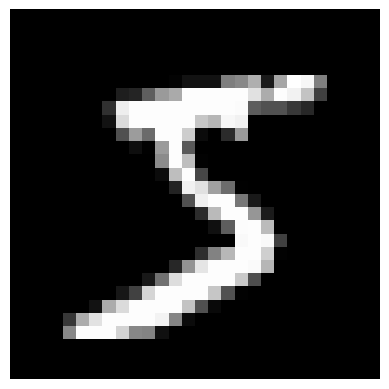

In [67]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())

image, label = mnist_dataset[0]
print("Label:" , label)

plt.imshow(image.squeeze(), cmap="gray")
plt.axis("off") 
plt.show()

## b) Implement sigmoid and ReLU layers

In [ ]:
import numpy as np

class SigmoidLayer:
    def __init__(self):
        pass
    
    def forward_pass(self, x):
        self.activation_output = 1 / (1 + np.exp(-x))
        return self.activation_output
    
    def backward_pass(self, activation):
        return (1 - activation) * activation
    

class ReLULayer:
    def __init__(self):
        self.epsilon = 1e-7  #small val so not exact 0 so negative values are not causing so many neurons to die
        
    def forward_pass(self, x):
        self.output = np.maximum(self.epsilon, x)
        return self.output
    
    def backward_pass(self, activation):
        return np.where(activation > self.epsilon, 1.0, 0.0)
    

class LeakyReLULayer:
    def forward_pass(self, x):
        return np.where(x > 0, x, 0.01 * x) #scale negative values by 0.01 and leave positive values 

    def backward_pass(self, activation):
        return np.where(activation > 0, 1.0, 0.01)

## c) Implement softmax layer

The goal of the softmax layer is to convert raw scores (logits) from the neural network into probabilites that sum to 1.

Here is the softmax formula: $ f(z)_i = \frac{(e^z)_i}{\Sigma_j^K(e^z)_j} $

In [69]:
import numpy as np
    
class SoftmaxLayer:
    def __init__(self):
        pass
    
    def forward_pass(self, inputs):
        #make sure the dimensions are correct shape
        if inputs.ndim == 1:
            inputs = inputs.reshape(-1, 1)

        #for numerical stability
        epsilon = 1e-7 #dont use exact zero
        shifted_inputs = inputs - np.max(inputs, axis=0, keepdims=True)
        exp_values = np.clip(np.exp(shifted_inputs), epsilon, 1e30) #prevent overflow by clipping if too large
        #normalise
        probabilities = exp_values / np.sum(exp_values, axis=0, keepdims=True)
        return probabilities
    
    def backward_pass(self, activation, target):
        #cross entropy loss
        return activation - target

## d) Implement dropout

The goal of the dropout layer is to improve the model's generalization and reduce overfitting by randomly temporarily disabling a fraction of the neurons during training, to prevent the model over-relying on specific neurons

In [ ]:
import numpy as np

class DropoutLayer:
    def __init__(self, rate):
        self.rate = rate
        self.mask = None

    def forward_pass(self, inputs, training=True):
        if not training or self.rate == 0: #skip dropout if not training
            return inputs
        self.mask = (np.random.rand(*inputs.shape) > self.rate) / (1 - self.rate) #generate mask
        return inputs * self.mask
    
    def backward_pass(self, gradient):
        return gradient * self.mask #scale the gradient by the same dropout mask used in the forward pass

## e) Implement a fully parametrizable neural network class

Feedforward neural network
You should implement a fully-connected NN class where with number of hidden
layers, units, activation functions can be changed. In addition, you can add dropout or
regularizer (L1 or L2). 


Report the parameters used (update rule, learning rate, decay,
epochs, batch size) and include the plots in your report.

## f) Implement optimizer

Originally, the optimisers were done in a seperate class however to make it less complex I have now included the following optimisers in-line: Minibatch, SGD, and momentum batch descent.

In [ ]:
class NeuraNetwork:
    def __init__(self, in_nodes, out_nodes, hidden_layers, hidden_activation, output_activation, optimizer, initialization='xavier',
                 dropoutRate=0.0, learning_rate=0.001, epochs=20, batch_size=32, momentum=0.0, 
                 regularization=None, lambda_=0.00, decay_rate=0.0, decay_steps=0, min_lr=1e-5):
        
        # Intialises the neural network 
        #Parameters
        # inNodes: number of input nodes
        # outNodes: number of output nodes
        # hidden_layers: list of number of neurons in each hidden layer. eg [128, 64, 32]
        # hidden_activation: activation function (uses the forward_pass and backpropagation methods) for hidden layers
        # output_activation: activation function for output layer 
        # initialization : choice of initializer for the weight matrices eg xavier for sigmoid or he for relu
        # dropoutRate: dropout rate to reduce overfitting
        # learning_rate: learning rate for training
        # epochs : the number of epochs that will run over the set
        # optimizer : the selected optimizer out of bdg, sgd, momentum
        # batch_size : size for minibatch optimiser
        # regularization: type of regularization l1 or l2
        # lambda_: regularization strength
        # decay_rate : rate that the learning rate decays by (decrease the learning rate as we get closer to convergence)
        # decay-steps : amount of step intervals we should apply the decay rate
        # min_lr : the smallest learning rate that will be used throught training

        self.in_nodes = in_nodes
        self.out_nodes = out_nodes
        self.hidden_layers = hidden_layers
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation
        self.initialization = initialization
        self.dropoutRate = dropoutRate
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.optimizer_type = optimizer
        self.batch_size = batch_size
        self.momentum = momentum
        self.regularization = regularization
        self.lambda_ = lambda_
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
        self.min_lr = min_lr

        self.create_weight_matrices()
        self.dropout_masks = []

    def create_weight_matrices(self):
        """initialize weights and biases using Xavier/He initialization."""
        self.weights = []
        self.biases = []

        if self.initialization == "xavier":
            #back to xavier based on yarik model with uniform distrubtion instead of truncated normal distribution
            #input layer to hidden layer
            limit = np.sqrt(6 / (self.in_nodes + self.hidden_layers[0]))
            self.weights.append(np.random.uniform(-limit, limit, (self.hidden_layers[0], self.in_nodes)))
            self.biases.append(np.zeros((self.hidden_layers[0], 1)))

            #hidden to hidden
            for i in range(1, len(self.hidden_layers)):
                limit = np.sqrt(6 / (self.hidden_layers[i - 1] + self.hidden_layers[i]))
                self.weights.append(np.random.uniform(-limit, limit, (self.hidden_layers[i], self.hidden_layers[i - 1])))
                self.biases.append(np.zeros((self.hidden_layers[i], 1)))

            #hidden to output
            limit = np.sqrt(6 / (self.hidden_layers[-1] + self.out_nodes))
            self.weights.append(np.random.uniform(-limit, limit, (self.out_nodes, self.hidden_layers[-1])))
            self.biases.append(np.zeros((self.out_nodes, 1)))

        elif self.initialization == "he":
            #He init for relu - input to hidden layer
            limit = np.sqrt(2 / self.in_nodes)
            self.weights.append(np.random.uniform(-limit, limit, (self.hidden_layers[0], self.in_nodes)))
            self.biases.append(np.zeros((self.hidden_layers[0], 1)))

            #hidden to hidden
            for i in range(1, len(self.hidden_layers)):
                limit = np.sqrt(2 / self.hidden_layers[i - 1])
                self.weights.append(np.random.uniform(-limit, limit, (self.hidden_layers[i], self.hidden_layers[i - 1])))
                self.biases.append(np.zeros((self.hidden_layers[i], 1)))
            
            #hidden to output
            limit = np.sqrt(2 / self.hidden_layers[-1])
            self.weights.append(np.random.uniform(-limit, limit, (self.out_nodes, self.hidden_layers[-1])))
            self.biases.append(np.zeros((self.out_nodes, 1)))

        else:
            raise ValueError("invalid initializer choice")

    def cross_entropy_loss(self, predicted, target):
        """cross entropy loss w/ regularization - helper func"""
        epsilon = 1e-7
        predicted = np.clip(predicted, epsilon, 1 - epsilon)
        loss = -np.sum(target * np.log(predicted))

        if self.regularization == 'L1':
            loss += self.lambda_ * sum(np.sum(np.abs(w)) for w in self.weights)
        elif self.regularization == 'L2':
            loss += self.lambda_ * sum(np.sum(w ** 2) for w in self.weights)

        return loss
    
    def forward_pass(self, input_vector, training=True):
        if input_vector.ndim == 1:
            input_vector = input_vector[:, None]  #ensure correct shape if single sample

        activations = [input_vector] #init the activations list to be the input vector 

        for i in range(len(self.weights) - 1): #for each layer in the nn up to output layer
            #calculate the z value of the neuron which is the dot product of This Layer's weights and the activations of the previous layer added with bias col vector [Z = W(L) * a(L-1) + b(L)]
            z = np.dot(self.weights[i], activations[-1]) + self.biases[i]
            a = self.hidden_activation.forward_pass(z) #calc the activation value with forward_pass method of the activation func sigmoid or ReLU / LeakyReLU

            #apply dropout during training (important to only do this during training only)
            if training and self.dropoutRate > 0:
                mask = np.random.binomial(1, 1 - self.dropoutRate, size=a.shape)
                a *= mask / (1 - self.dropoutRate)  #scale by inverse

            activations.append(a) #update the list of activations, the final nn output is activations[-1] 
            
        #output layer activations
        z_final = np.dot(self.weights[-1], activations[-1]) + self.biases[-1]
        a_final = self.output_activation.forward_pass(z_final)
        activations.append(a_final)

        return activations

    def backpropagation(self, activations, target_vector):
        """perform backward pass to compute gradients"""
        deltas = [self.output_activation.backward_pass(activations[-1], target_vector)] #computes the output layer softmax error
        gradients_w = []
        gradients_b = []

        #starting from the final layer back to the first layer 
        for i in reversed(range(len(self.weights))):
            #weight gradient dL/dW(L) is computed as the outer product of delta/error [dL/dZ(L)] and the activations of the prev layer a(L-1)
            grad_w = np.dot(deltas[-1], activations[i].T)
            #bias gradient dL/db(L) is just the sum of delta (dL/dZ(L)) across all samples
            grad_b = np.sum(deltas[-1], axis=1, keepdims=True)

            #clipping to avoid extreme gradients and explosion that we were seeing before
            grad_norm = np.linalg.norm(grad_w)
            if grad_norm > 1.0:
                grad_w /= (grad_norm + 1e-7)

            gradients_w.insert(0, grad_w)
            gradients_b.insert(0, grad_b)

            if i > 0:
                #ok so derivative of output error with respect to weight dL/dW(L) = (a(L) - y) * a(L)(1-a(L)) * a(L-1) (in the case of sigmoid)
                #deltas[-1] contains (a(L) - y)
                #so we multiply it (dot product) by the derivative of the activation function a(L)(1-a(L)) (for sigmoid example) 
                #W(L) is the weight matrix for the current layer
                #so delta = dL/dZ = dL/dA * dA/dZ. 
                delta = np.dot(self.weights[i].T, deltas[-1]) * self.hidden_activation.backward_pass(activations[i])
                deltas.append(delta)

        return gradients_w, gradients_b

    def apply_optimizer(self, gradients_w, gradients_b):
        """applying optimiser logic in nn class as opposed to seperate class"""
        #applying the regularization logic
        for i in range(len(self.weights)):
            if self.regularization == 'L1':
                gradients_w[i] += self.lambda_ * np.sign(self.weights[i])
            elif self.regularization == 'L2':
                gradients_w[i] += self.lambda_ * self.weights[i]

            if self.optimizer_type == 'momentum': #momentum batch descent we need to compute the velocities so that we can have momentum when finding minima
                self.velocities_w[i] = self.momentum * self.velocities_w[i] - self.learning_rate * gradients_w[i]
                self.velocities_b[i] = self.momentum * self.velocities_b[i] - self.learning_rate * gradients_b[i]
                self.weights[i] += self.velocities_w[i]
                self.biases[i] += self.velocities_b[i]
            else:
                self.weights[i] -= self.learning_rate * gradients_w[i]
                self.biases[i] -= self.learning_rate * gradients_b[i]

    def apply_decay(self, epoch):
        """decay helper function"""
        if epoch % self.decay_steps == 0: #apply decay every n steps
            self.learning_rate = max(self.learning_rate * self.decay_rate, self.min_lr)

    def train(self, input_data, target_data):
        input_data = input_data.T
        target_data = target_data.T

        #keep track of statistics from training  - using list for each one so i can graph it later
        history = {'loss': [], 'accuracy': [], 'learning_rate': []}

        if self.optimizer_type == 'momentum': #initalize momentums velocities
            self.velocities_w = [np.zeros_like(w) for w in self.weights]
            self.velocities_b = [np.zeros_like(b) for b in self.biases]

        for epoch in range(self.epochs): #for every epoch we go thru every sample and do a full forward pass and backpropagation and update of weights and biases

            #reset these values each loop
            total_loss = 0
            correct_predictions = 0

            if(self.decay_rate > 0.0):
                self.apply_decay(epoch) #apply the decay to lr

            if self.optimizer_type == 'minibgd': 
                num_batches = input_data.shape[1] // self.batch_size #split into batches based on the batch size 
                for batch in range(num_batches):
                    batch_start = batch * self.batch_size
                    batch_end = batch_start + self.batch_size
                    batch_inputs = input_data[:, batch_start:batch_end]
                    batch_targets = target_data[:, batch_start:batch_end]

                    batch_gradients_w = [np.zeros_like(w) for w in self.weights]
                    batch_gradients_b = [np.zeros_like(b) for b in self.biases]

                    for sample in range(batch_inputs.shape[1]): #for each sample in each batch
                        input_vector = batch_inputs[:, [sample]] #[sample] gives me back each column vector in matrix instead of 1D row
                        target_vector = batch_targets[:, [sample]]

                        #forward pass
                        activations = self.forward_pass(input_vector, training=True)

                        #calc cross-entropy loss
                        loss = self.cross_entropy_loss(activations[-1], target_vector)
                        total_loss += loss

                        #accuracy and correct predictions based on the final layer activations
                        predicted = np.argmax(activations[-1])
                        true_label = np.argmax(target_vector)
                        if predicted == true_label:
                            correct_predictions += 1

                        #backpropagation
                        gradients_w, gradients_b = self.backpropagation(activations, target_vector)

                        #accumulate the batch gradients
                        for i in range(len(self.weights)):
                            batch_gradients_w[i] += gradients_w[i]
                            batch_gradients_b[i] += gradients_b[i]

                    #avg gradient for the batch
                    for i in range(len(self.weights)):
                        batch_gradients_w[i] /= batch_inputs.shape[1]
                        batch_gradients_b[i] /= batch_inputs.shape[1]

                    self.apply_optimizer(batch_gradients_w, batch_gradients_b)

            elif self.optimizer_type == 'sgd': 
                for _ in range(input_data.shape[1] // self.batch_size): 
                    #randomly select batch
                    random_indices = np.random.choice(input_data.shape[1], self.batch_size, replace=False)
                    input_batch = input_data[:, random_indices]
                    target_batch = target_data[:, random_indices]

                    #forward pass
                    activations = self.forward_pass(input_batch, training=True)

                    #calc cros-entropy loss
                    loss = self.cross_entropy_loss(activations[-1], target_batch)
                    total_loss += loss

                    #accuracy and correct predictions based on the final layer activations
                    predicted = np.argmax(activations[-1], axis=0)
                    true_labels = np.argmax(target_batch, axis=0)
                    correct_predictions += np.sum(predicted == true_labels)

                    #backpropagation
                    gradients_w, gradients_b = self.backpropagation(activations, target_batch)
                    
                    self.apply_optimizer(gradients_w, gradients_b)
            
            elif self.optimizer_type == 'momentum':
                for sample_idx in range(input_data.shape[1]):
                    input_vector = input_data[:, [sample_idx]]
                    target_vector = target_data[:, [sample_idx]]

                    #forward pass
                    activations = self.forward_pass(input_vector, training=True)

                    #calc cros-entropy loss
                    loss = self.cross_entropy_loss(activations[-1], target_vector)
                    total_loss += loss

                    #accuracy and correct predictions based on the final layer activations
                    predicted = np.argmax(activations[-1])
                    true_label = np.argmax(target_vector)
                    if predicted == true_label:
                        correct_predictions += 1

                    #backpropagation
                    gradients_w, gradients_b = self.backpropagation(activations, target_vector)

                    #update weights with momentum
                    self.apply_optimizer(gradients_w, gradients_b)

            else: #batch by default
                #initialise the gradients that get accumulated for each sample
                accumulated_gradients_w = [np.zeros_like(w) for w in self.weights] 
                accumulated_gradients_b = [np.zeros_like(b) for b in self.biases]

                for sample in range(input_data.shape[1]): #input_data.shape[1] is number of samples
                    input_vector = input_data[:, [sample]] 
                    target_vector = target_data[:, [sample]]

                    #forward pass
                    activations = self.forward_pass(input_vector, training=True)

                    #calc cross-entropy loss
                    loss = self.cross_entropy_loss(activations[-1], target_vector)
                    total_loss += loss

                    #accuracy and correct predictions based on the final layer activations
                    predicted = np.argmax(activations[-1])
                    true_label = np.argmax(target_vector)
                    if predicted == true_label:
                        correct_predictions += 1

                    #backpropagation
                    gradients_w, gradients_b = self.backpropagation(activations, target_vector)

                    #accumulate the batch gradients
                    for i in range(len(self.weights)):
                        accumulated_gradients_w[i] += gradients_w[i]
                        accumulated_gradients_b[i] += gradients_b[i]

                #avg gradient for all samples (mean)
                for i in range(len(self.weights)):
                    accumulated_gradients_w[i] /= input_data.shape[1]
                    accumulated_gradients_b[i] /= input_data.shape[1]

                self.apply_optimizer(accumulated_gradients_w, accumulated_gradients_b)

            #stats for every epoch
            avg_loss = total_loss / input_data.shape[1]
            accuracy = correct_predictions / input_data.shape[1] * 100
            history['loss'].append(avg_loss)
            history['accuracy'].append(accuracy)
            history['learning_rate'].append(self.learning_rate)
            print(f"Epoch {epoch + 1}/{self.epochs} - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.2f}% - LR: {self.learning_rate:.6f}")

        return history
    
    def run(self, input_data):
        """running the test set"""
        if input_data.ndim == 1: #handle if only a single sample is passed
            input_data = input_data[:, None]
        activations = self.forward_pass(input_data, training=False) #do a full forward pass and then return the final layer activations
        return activations[-1]


## g) Evaluate different neural network architectures/parameters, present and discuss your results. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

#dataset split
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

train_images = mnist_train.data.numpy().reshape(-1, 28*28) / 255.0  #norm to [0,1]
train_labels = mnist_train.targets.numpy()
test_images = mnist_test.data.numpy().reshape(-1, 28*28) / 255.0
test_labels = mnist_test.targets.numpy()

val_size = len(train_images) // 10
val_images = train_images[:val_size]
val_labels = train_labels[:val_size]
train_images = train_images[val_size:]
train_labels = train_labels[val_size:]

def one_hot_encode(labels, num_classes=10): #for making the 10 classes
    return np.eye(num_classes)[labels]

train_labels_one_hot = one_hot_encode(train_labels)
val_labels_one_hot = one_hot_encode(val_labels)
test_labels_one_hot = one_hot_encode(test_labels)

#### baseline - sigmoid xavier default params - batch gradient descent

Starting training...
Epoch 1/20 - Loss: 2.1999 - Accuracy: 21.89%
Epoch 2/20 - Loss: 1.6017 - Accuracy: 51.38%
Epoch 3/20 - Loss: 1.0766 - Accuracy: 66.91%
Epoch 4/20 - Loss: 0.8229 - Accuracy: 74.10%
Epoch 5/20 - Loss: 0.6910 - Accuracy: 78.36%
Epoch 6/20 - Loss: 0.6124 - Accuracy: 80.83%
Epoch 7/20 - Loss: 0.5667 - Accuracy: 82.36%
Epoch 8/20 - Loss: 0.5379 - Accuracy: 83.68%
Epoch 9/20 - Loss: 0.5209 - Accuracy: 84.15%
Epoch 10/20 - Loss: 0.5062 - Accuracy: 84.98%
Epoch 11/20 - Loss: 0.4922 - Accuracy: 85.51%
Epoch 12/20 - Loss: 0.4809 - Accuracy: 86.04%
Epoch 13/20 - Loss: 0.4763 - Accuracy: 86.22%
Epoch 14/20 - Loss: 0.4667 - Accuracy: 86.49%
Epoch 15/20 - Loss: 0.4599 - Accuracy: 86.82%
Epoch 16/20 - Loss: 0.4548 - Accuracy: 87.18%
Epoch 17/20 - Loss: 0.4484 - Accuracy: 87.56%
Epoch 18/20 - Loss: 0.4436 - Accuracy: 87.63%
Epoch 19/20 - Loss: 0.4388 - Accuracy: 87.81%
Epoch 20/20 - Loss: 0.4360 - Accuracy: 87.72%


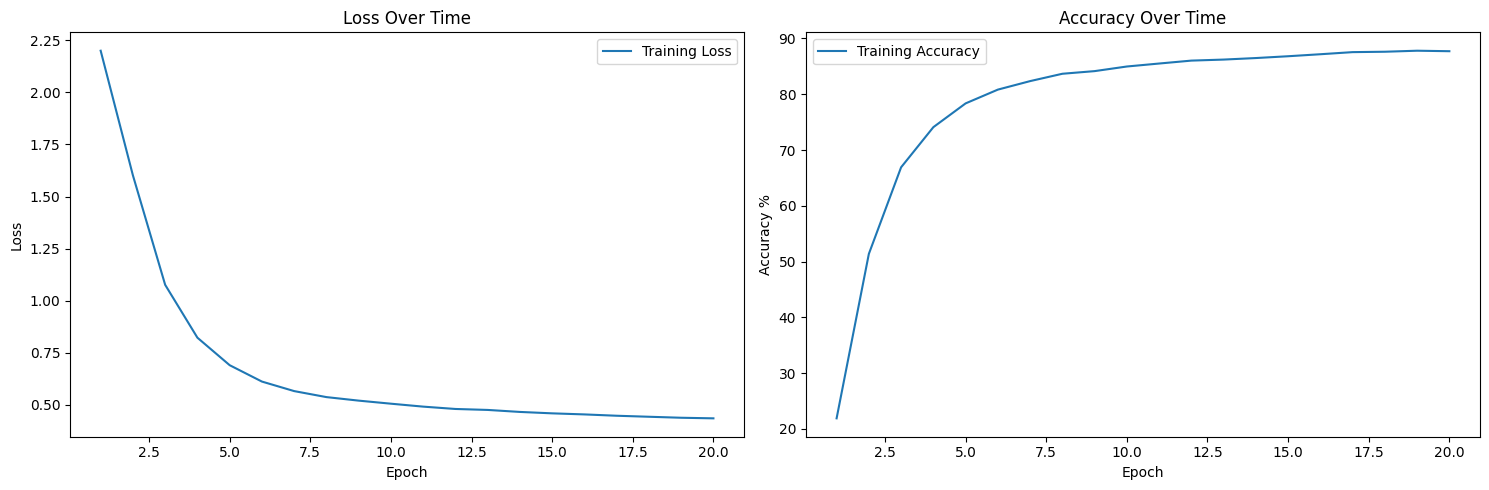


Evaluating on test set...
Test Set Performance:
Loss: 0.3281
Accuracy: 90.66%


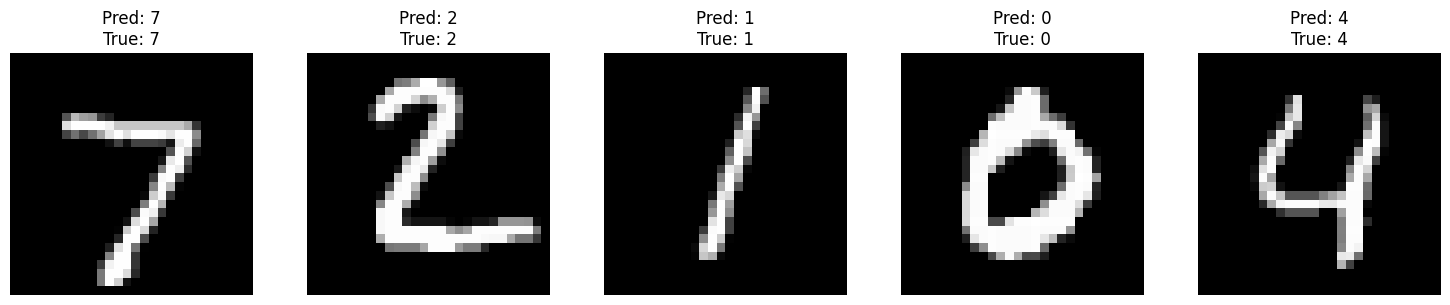

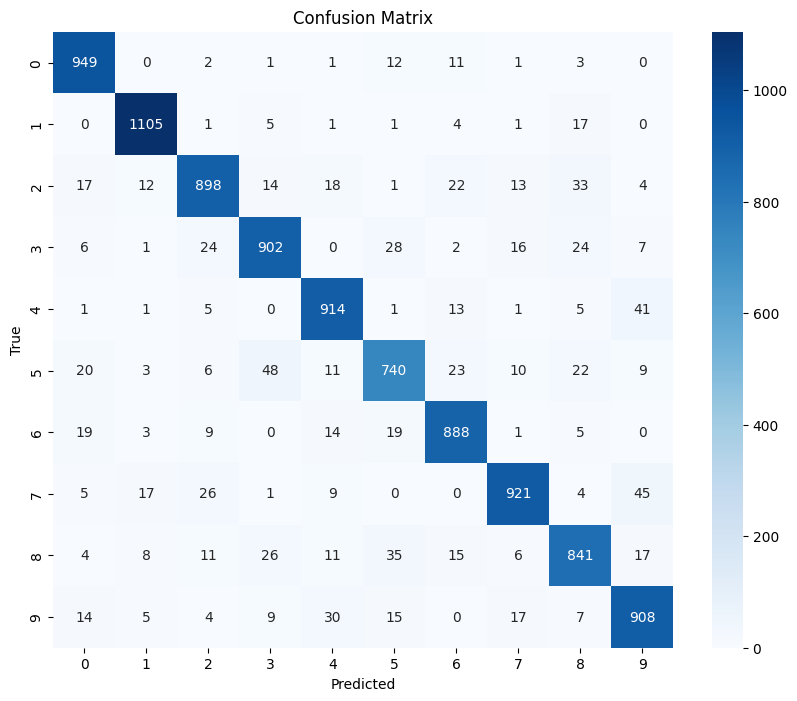


Detailed metrics for each digit:
Digit 0 accuracy: 96.84%
Digit 1 accuracy: 97.36%
Digit 2 accuracy: 87.02%
Digit 3 accuracy: 89.31%
Digit 4 accuracy: 93.08%
Digit 5 accuracy: 82.96%
Digit 6 accuracy: 92.69%
Digit 7 accuracy: 89.59%
Digit 8 accuracy: 86.34%
Digit 9 accuracy: 89.99%


In [40]:
#batch descent default
nn = NeuraNetwork(
    in_nodes=784,             #28x28 pixels flattened
    out_nodes=10,             #10 digits
    hidden_layers=[128, 64],  
    hidden_activation=SigmoidLayer(),    
    output_activation=SoftmaxLayer(),   
    initialization='xavier',
    dropoutRate=0.2,          
    learning_rate=0.001,      
    epochs=20,                
    optimizer='bgd',     
)

print("Starting training...")
history = nn.train(train_images, train_labels_one_hot)

plt.figure(figsize=(15, 5))

#loss graph
plt.subplot(1, 2, 1)
plt.plot(range(1, nn.epochs + 1), history['loss'], label='Training Loss')
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#accuracy graph
plt.subplot(1, 2, 2)
plt.plot(range(1, nn.epochs + 1), history['accuracy'], label='Training Accuracy')
plt.title('Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.legend()

plt.tight_layout()
plt.show()

#test set
print("\nEvaluating on test set...")
test_predictions = nn.run(test_images.T)
predicted_classes = np.argmax(test_predictions, axis=0)
true_classes = np.argmax(test_labels_one_hot, axis=1)

test_loss = nn.cross_entropy_loss(test_predictions, test_labels_one_hot.T) / len(test_labels_one_hot)
test_accuracy = np.mean(predicted_classes == true_classes) * 100
print(f"Test Set Performance:")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_accuracy:.2f}%")

num_samples = 5
plt.figure(figsize=(15, 3))

for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    test_sample = test_images[i]
    sample_prediction = nn.run(test_sample[:, None])
    predicted_class = np.argmax(sample_prediction)
    true_class = np.argmax(test_labels_one_hot[i])

    plt.imshow(test_sample.reshape(28, 28), cmap='gray')
    plt.title(f'Pred: {predicted_class}\nTrue: {true_class}')
    plt.axis('off')

plt.tight_layout()
plt.show()

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print("\nDetailed metrics for each digit:")
for digit in range(10):
    mask = (true_classes == digit)
    digit_accuracy = (predicted_classes[mask] == true_classes[mask]).mean() * 100
    print(f"Digit {digit} accuracy: {digit_accuracy:.2f}%")


#### sigmoid - xavier - momentum  - default params

Starting training...
Epoch 1/20 - Loss: 0.9008 - Accuracy: 70.89% - LR: 0.001000
Epoch 2/20 - Loss: 0.4611 - Accuracy: 86.88% - LR: 0.001000
Epoch 3/20 - Loss: 0.4171 - Accuracy: 88.64% - LR: 0.001000
Epoch 4/20 - Loss: 0.3835 - Accuracy: 89.79% - LR: 0.001000
Epoch 5/20 - Loss: 0.3692 - Accuracy: 90.17% - LR: 0.001000
Epoch 6/20 - Loss: 0.3508 - Accuracy: 90.86% - LR: 0.001000
Epoch 7/20 - Loss: 0.3373 - Accuracy: 91.36% - LR: 0.001000
Epoch 8/20 - Loss: 0.3247 - Accuracy: 91.65% - LR: 0.001000
Epoch 9/20 - Loss: 0.3160 - Accuracy: 91.91% - LR: 0.001000
Epoch 10/20 - Loss: 0.3049 - Accuracy: 92.36% - LR: 0.001000
Epoch 11/20 - Loss: 0.2970 - Accuracy: 92.49% - LR: 0.001000
Epoch 12/20 - Loss: 0.2896 - Accuracy: 92.74% - LR: 0.001000
Epoch 13/20 - Loss: 0.2874 - Accuracy: 92.80% - LR: 0.001000
Epoch 14/20 - Loss: 0.2797 - Accuracy: 92.94% - LR: 0.001000
Epoch 15/20 - Loss: 0.2767 - Accuracy: 93.05% - LR: 0.001000
Epoch 16/20 - Loss: 0.2714 - Accuracy: 93.16% - LR: 0.001000
Epoch 17/20 

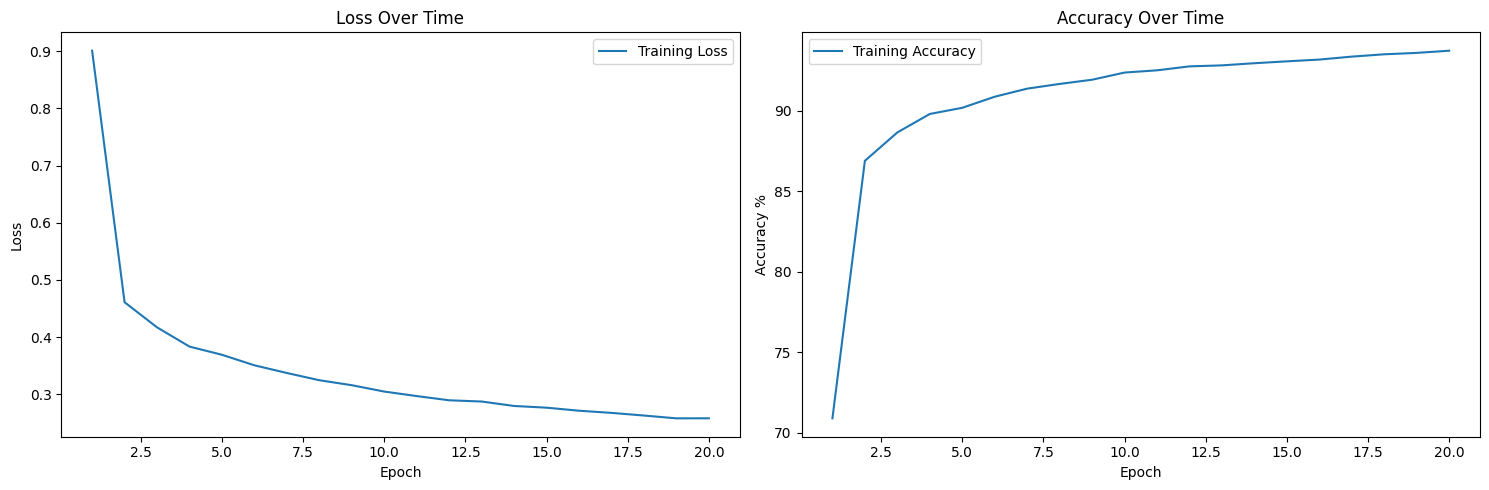


Evaluating on test set...
Test Set Performance:
Loss: 0.1854
Accuracy: 95.30%


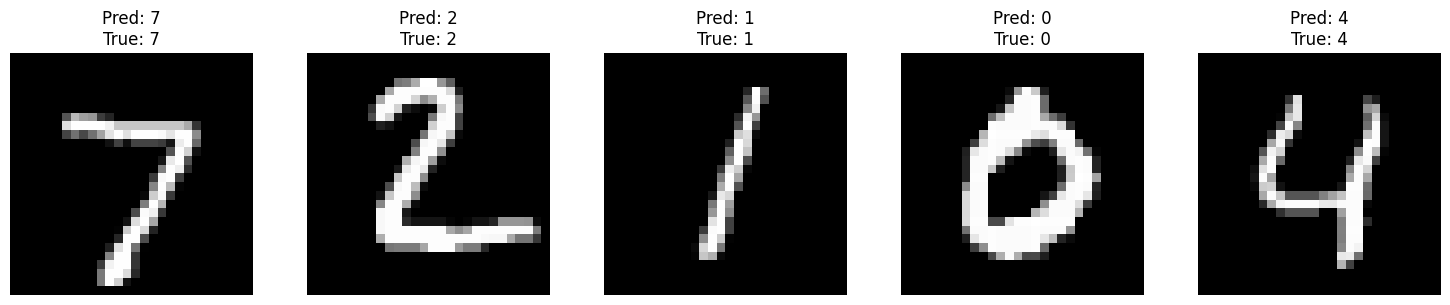

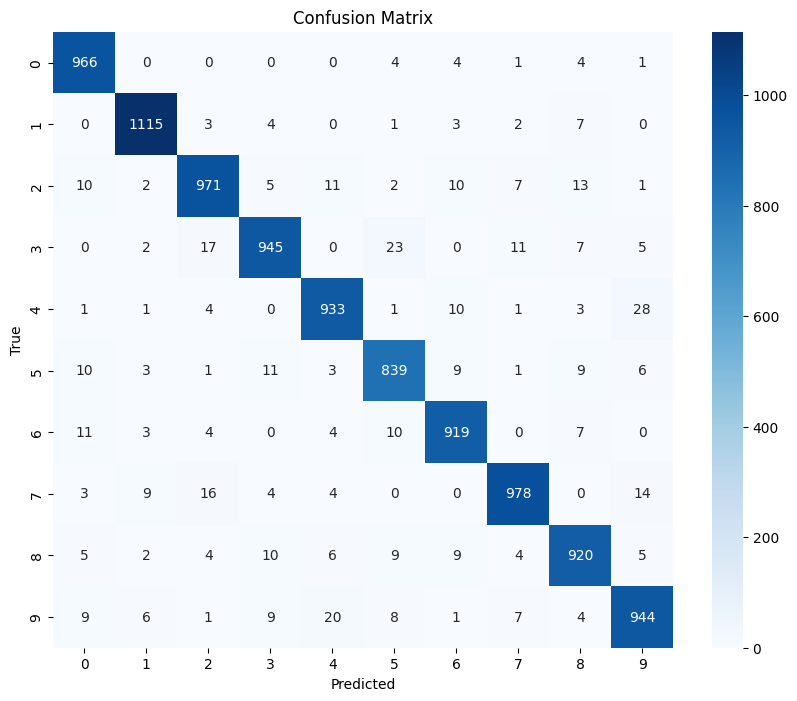


Detailed metrics for each digit:
Digit 0 accuracy: 98.57%
Digit 1 accuracy: 98.24%
Digit 2 accuracy: 94.09%
Digit 3 accuracy: 93.56%
Digit 4 accuracy: 95.01%
Digit 5 accuracy: 94.06%
Digit 6 accuracy: 95.93%
Digit 7 accuracy: 95.14%
Digit 8 accuracy: 94.46%
Digit 9 accuracy: 93.56%


In [73]:
#momentum default
nn = NeuraNetwork(
    in_nodes=784,             #28x28 pixels flattened
    out_nodes=10,             #10 digits
    hidden_layers=[128, 64],  
    hidden_activation=SigmoidLayer(),    
    output_activation=SoftmaxLayer(),   
    initialization='xavier',
    dropoutRate=0.2,          
    learning_rate=0.001,      
    epochs=20,                
    optimizer='momentum',     
    momentum=0.9              
)

print("Starting training...")
history = nn.train(train_images, train_labels_one_hot)

plt.figure(figsize=(15, 5))

#loss graph
plt.subplot(1, 2, 1)
plt.plot(range(1, nn.epochs + 1), history['loss'], label='Training Loss')
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#accuracy graph
plt.subplot(1, 2, 2)
plt.plot(range(1, nn.epochs + 1), history['accuracy'], label='Training Accuracy')
plt.title('Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.legend()

plt.tight_layout()
plt.show()

#test set
print("\nEvaluating on test set...")
test_predictions = nn.run(test_images.T)
predicted_classes = np.argmax(test_predictions, axis=0)
true_classes = np.argmax(test_labels_one_hot, axis=1)

test_loss = nn.cross_entropy_loss(test_predictions, test_labels_one_hot.T) / len(test_labels_one_hot)
test_accuracy = np.mean(predicted_classes == true_classes) * 100
print(f"Test Set Performance:")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_accuracy:.2f}%")

num_samples = 5
plt.figure(figsize=(15, 3))

for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    test_sample = test_images[i]
    sample_prediction = nn.run(test_sample[:, None])
    predicted_class = np.argmax(sample_prediction)
    true_class = np.argmax(test_labels_one_hot[i])

    plt.imshow(test_sample.reshape(28, 28), cmap='gray')
    plt.title(f'Pred: {predicted_class}\nTrue: {true_class}')
    plt.axis('off')

plt.tight_layout()
plt.show()

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print("\nDetailed metrics for each digit:")
for digit in range(10):
    mask = (true_classes == digit)
    digit_accuracy = (predicted_classes[mask] == true_classes[mask]).mean() * 100
    print(f"Digit {digit} accuracy: {digit_accuracy:.2f}%")


#### relu - He - agressive learning - stochastic gradient descent

Starting training...
Epoch 1/20 - Loss: 0.6850 - Accuracy: 80.87% - LR: 0.010000
Epoch 2/20 - Loss: 0.7009 - Accuracy: 84.34% - LR: 0.010000
Epoch 3/20 - Loss: 0.7878 - Accuracy: 83.74% - LR: 0.010000
Epoch 4/20 - Loss: 0.8387 - Accuracy: 83.40% - LR: 0.010000
Epoch 5/20 - Loss: 0.9003 - Accuracy: 83.08% - LR: 0.010000
Epoch 6/20 - Loss: 0.9623 - Accuracy: 83.26% - LR: 0.010000
Epoch 7/20 - Loss: 0.9929 - Accuracy: 83.23% - LR: 0.010000
Epoch 8/20 - Loss: 1.0026 - Accuracy: 82.28% - LR: 0.010000
Epoch 9/20 - Loss: 1.0413 - Accuracy: 82.15% - LR: 0.010000
Epoch 10/20 - Loss: 1.0817 - Accuracy: 82.13% - LR: 0.010000
Epoch 11/20 - Loss: 1.0877 - Accuracy: 82.51% - LR: 0.010000
Epoch 12/20 - Loss: 1.1228 - Accuracy: 81.33% - LR: 0.010000
Epoch 13/20 - Loss: 1.1431 - Accuracy: 81.18% - LR: 0.010000
Epoch 14/20 - Loss: 1.1510 - Accuracy: 81.65% - LR: 0.010000
Epoch 15/20 - Loss: 1.2074 - Accuracy: 80.47% - LR: 0.010000
Epoch 16/20 - Loss: 1.2662 - Accuracy: 80.01% - LR: 0.010000
Epoch 17/20 

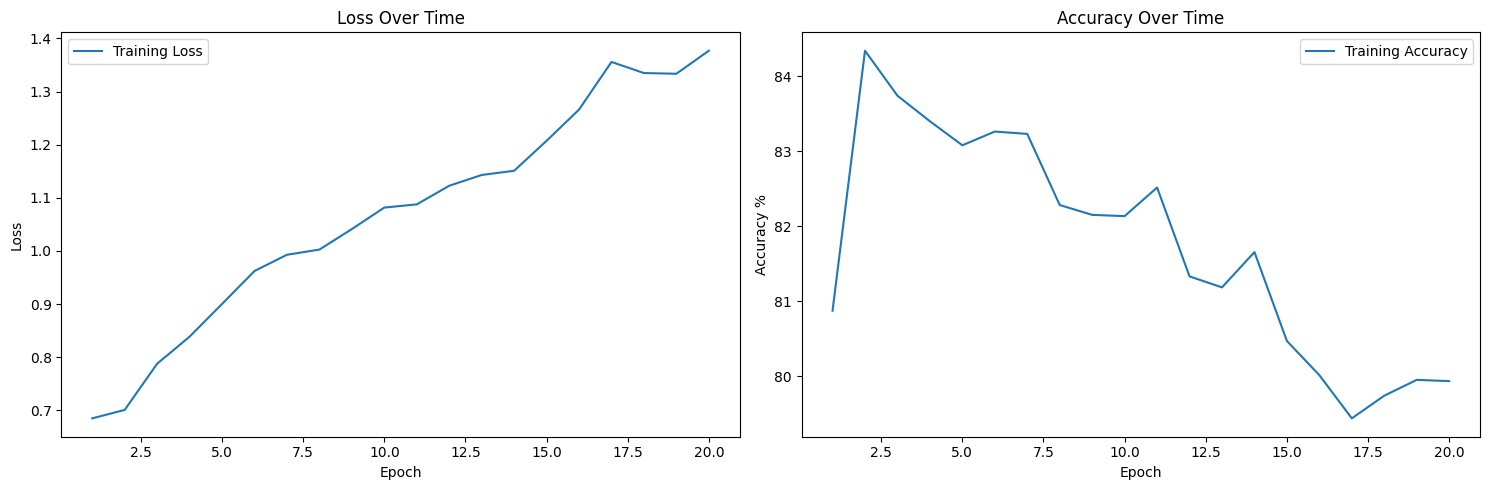


Evaluating on test set...
Test Set Performance:
Loss: 1.1004
Accuracy: 83.45%


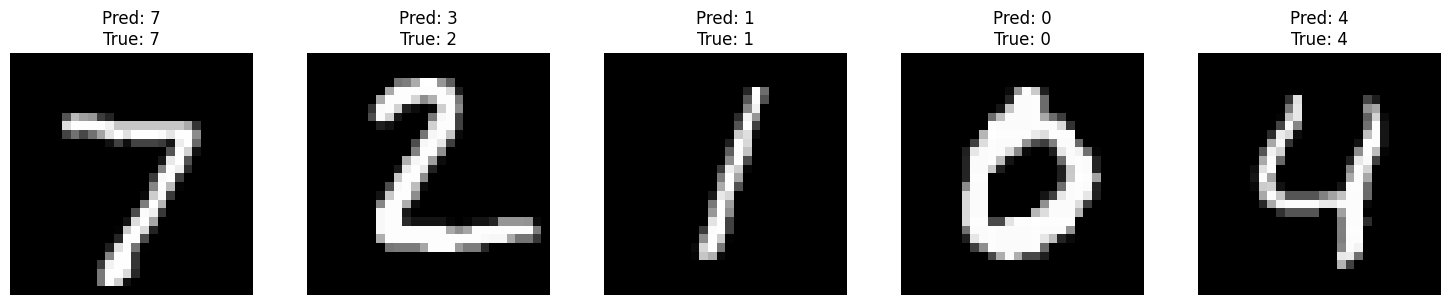

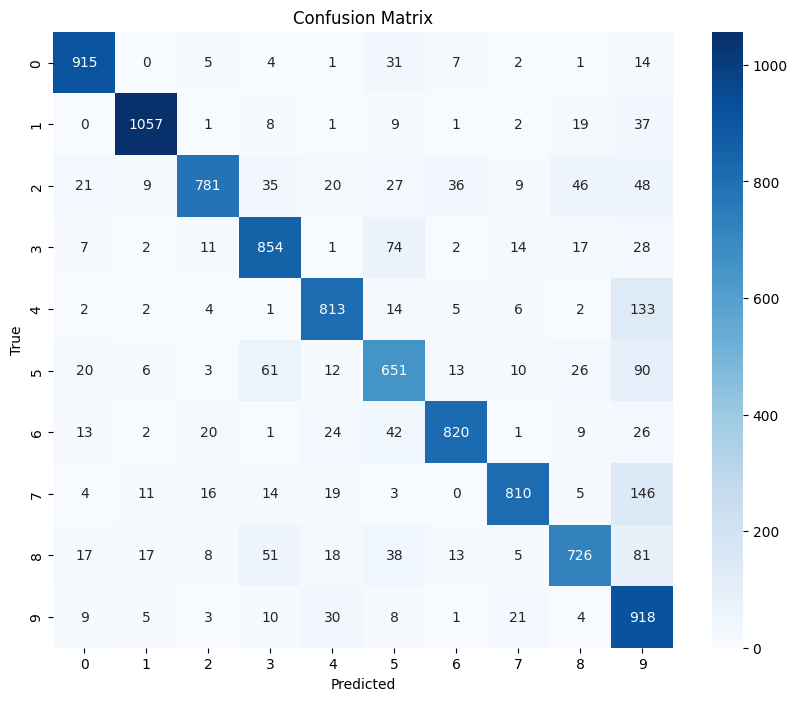


Detailed metrics for each digit:
Digit 0 accuracy: 93.37%
Digit 1 accuracy: 93.13%
Digit 2 accuracy: 75.68%
Digit 3 accuracy: 84.55%
Digit 4 accuracy: 82.79%
Digit 5 accuracy: 72.98%
Digit 6 accuracy: 85.59%
Digit 7 accuracy: 78.79%
Digit 8 accuracy: 74.54%
Digit 9 accuracy: 90.98%


In [76]:
#relu with agressive learning rate and sgd
nn = NeuraNetwork(
    in_nodes=784,             # 28x28 pixels flattened
    out_nodes=10,             # 10 digits
    hidden_layers=[128, 64],  
    hidden_activation=ReLULayer(),
    output_activation=SoftmaxLayer(),
    initialization='he',
    dropoutRate=0.2,
    learning_rate=0.01,
    epochs=20,
    optimizer='sgd',
)

print("Starting training...")
history = nn.train(train_images, train_labels_one_hot)

plt.figure(figsize=(15, 5))

#loss graph
plt.subplot(1, 2, 1)
plt.plot(range(1, nn.epochs + 1), history['loss'], label='Training Loss')
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#accuracy graph
plt.subplot(1, 2, 2)
plt.plot(range(1, nn.epochs + 1), history['accuracy'], label='Training Accuracy')
plt.title('Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.legend()

plt.tight_layout()
plt.show()

#test set
print("\nEvaluating on test set...")
test_predictions = nn.run(test_images.T)
predicted_classes = np.argmax(test_predictions, axis=0)
true_classes = np.argmax(test_labels_one_hot, axis=1)

test_loss = nn.cross_entropy_loss(test_predictions, test_labels_one_hot.T) / len(test_labels_one_hot)
test_accuracy = np.mean(predicted_classes == true_classes) * 100
print(f"Test Set Performance:")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_accuracy:.2f}%")

num_samples = 5
plt.figure(figsize=(15, 3))

for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    test_sample = test_images[i]
    sample_prediction = nn.run(test_sample[:, None])
    predicted_class = np.argmax(sample_prediction)
    true_class = np.argmax(test_labels_one_hot[i])

    plt.imshow(test_sample.reshape(28, 28), cmap='gray')
    plt.title(f'Pred: {predicted_class}\nTrue: {true_class}')
    plt.axis('off')

plt.tight_layout()
plt.show()

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print("\nDetailed metrics for each digit:")
for digit in range(10):
    mask = (true_classes == digit)
    digit_accuracy = (predicted_classes[mask] == true_classes[mask]).mean() * 100
    print(f"Digit {digit} accuracy: {digit_accuracy:.2f}%")


#### relu - He - gentle learning rate - sgd - L2  - decay 

Starting training...
Epoch 1/20 - Loss: 1.5552 - Accuracy: 57.91% - LR: 0.000900
Epoch 2/20 - Loss: 0.9209 - Accuracy: 75.95% - LR: 0.000900
Epoch 3/20 - Loss: 0.8322 - Accuracy: 80.82% - LR: 0.000900
Epoch 4/20 - Loss: 0.8257 - Accuracy: 82.56% - LR: 0.000900
Epoch 5/20 - Loss: 0.8403 - Accuracy: 83.10% - LR: 0.000900
Epoch 6/20 - Loss: 0.8606 - Accuracy: 83.33% - LR: 0.000810
Epoch 7/20 - Loss: 0.8754 - Accuracy: 83.39% - LR: 0.000810
Epoch 8/20 - Loss: 0.8885 - Accuracy: 83.58% - LR: 0.000810
Epoch 9/20 - Loss: 0.9013 - Accuracy: 83.59% - LR: 0.000810
Epoch 10/20 - Loss: 0.9237 - Accuracy: 83.61% - LR: 0.000810
Epoch 11/20 - Loss: 0.9476 - Accuracy: 83.40% - LR: 0.000729
Epoch 12/20 - Loss: 0.9693 - Accuracy: 83.00% - LR: 0.000729
Epoch 13/20 - Loss: 0.9902 - Accuracy: 82.58% - LR: 0.000729
Epoch 14/20 - Loss: 1.0073 - Accuracy: 82.36% - LR: 0.000729
Epoch 15/20 - Loss: 1.0218 - Accuracy: 82.23% - LR: 0.000729
Epoch 16/20 - Loss: 1.0353 - Accuracy: 82.30% - LR: 0.000656
Epoch 17/20 

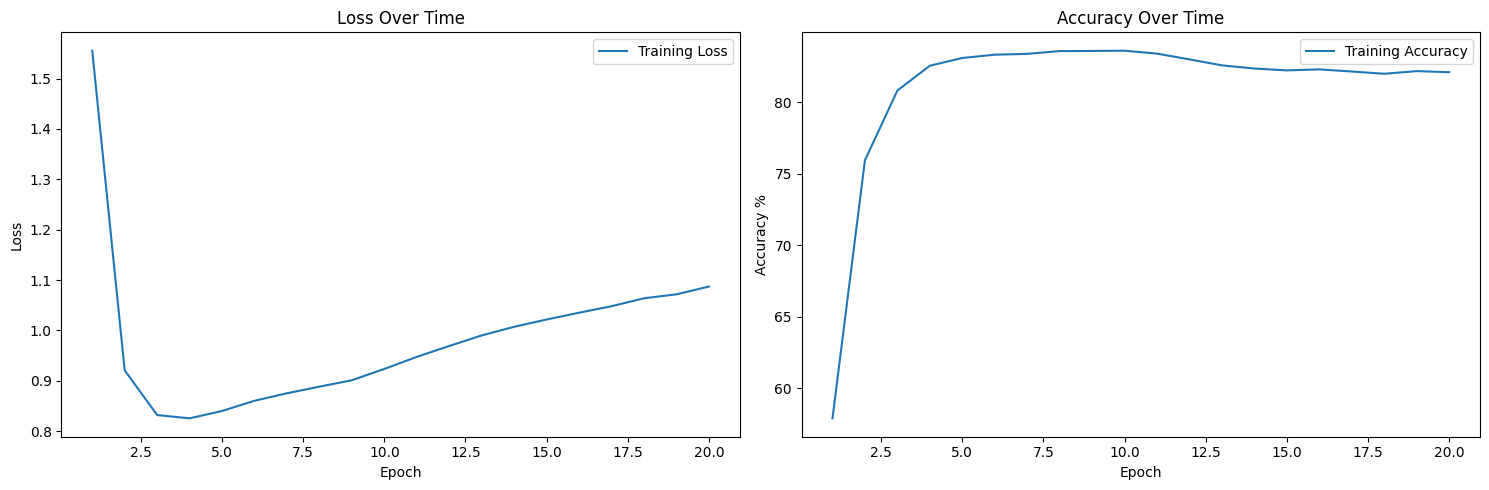


Evaluating on test set...
Test Set Performance:
Loss: 0.5724
Accuracy: 85.30%


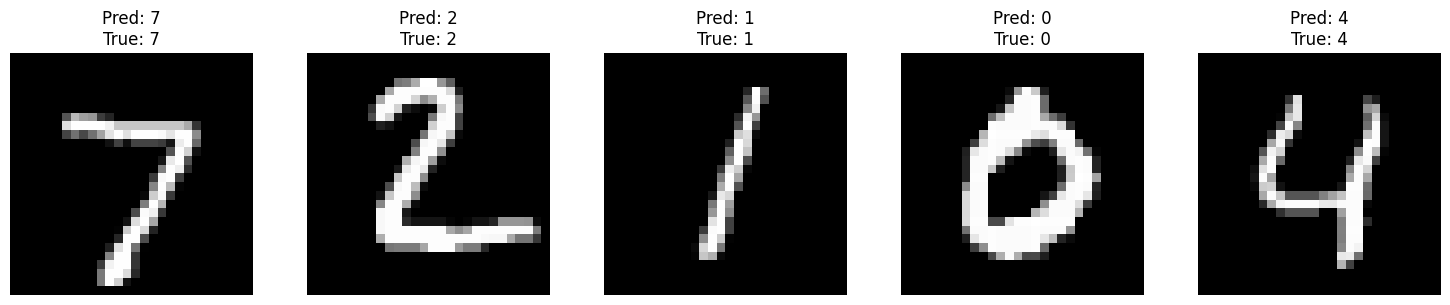

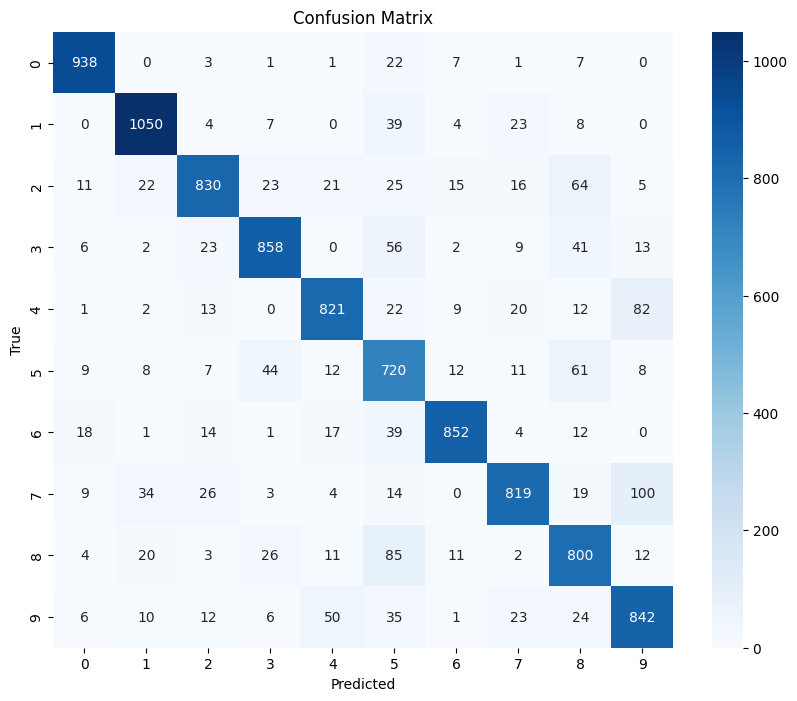


Detailed metrics for each digit:
Digit 0 accuracy: 95.71%
Digit 1 accuracy: 92.51%
Digit 2 accuracy: 80.43%
Digit 3 accuracy: 84.95%
Digit 4 accuracy: 83.60%
Digit 5 accuracy: 80.72%
Digit 6 accuracy: 88.94%
Digit 7 accuracy: 79.67%
Digit 8 accuracy: 82.14%
Digit 9 accuracy: 83.45%


In [ ]:
#relu with gentle learning rate and sgd and regularisation for stability + decay to lessen learning rate over time
nn = NeuraNetwork(
    in_nodes=784,             # 28x28 pixels flattened
    out_nodes=10,             # 10 digits
    hidden_layers=[128, 64],  
    hidden_activation=ReLULayer(),
    output_activation=SoftmaxLayer(),
    initialization='he',
    dropoutRate=0.2,
    learning_rate=0.001,
    epochs=20,
    optimizer='sgd',
    regularization='L2',      
    lambda_=0.001,            
    decay_rate=0.9,           
    decay_steps=5,            
    min_lr=1e-5
)

print("Starting training...")
history = nn.train(train_images, train_labels_one_hot)

plt.figure(figsize=(15, 5))

#loss graph
plt.subplot(1, 2, 1)
plt.plot(range(1, nn.epochs + 1), history['loss'], label='Training Loss')
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#accuracy graph
plt.subplot(1, 2, 2)
plt.plot(range(1, nn.epochs + 1), history['accuracy'], label='Training Accuracy')
plt.title('Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.legend()

plt.tight_layout()
plt.show()

#test set
print("\nEvaluating on test set...")
test_predictions = nn.run(test_images.T)
predicted_classes = np.argmax(test_predictions, axis=0)
true_classes = np.argmax(test_labels_one_hot, axis=1)

test_loss = nn.cross_entropy_loss(test_predictions, test_labels_one_hot.T) / len(test_labels_one_hot)
test_accuracy = np.mean(predicted_classes == true_classes) * 100
print(f"Test Set Performance:")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_accuracy:.2f}%")

num_samples = 5
plt.figure(figsize=(15, 3))

for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    test_sample = test_images[i]
    sample_prediction = nn.run(test_sample[:, None])
    predicted_class = np.argmax(sample_prediction)
    true_class = np.argmax(test_labels_one_hot[i])

    plt.imshow(test_sample.reshape(28, 28), cmap='gray')
    plt.title(f'Pred: {predicted_class}\nTrue: {true_class}')
    plt.axis('off')

plt.tight_layout()
plt.show()

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print("\nDetailed metrics for each digit:")
for digit in range(10):
    mask = (true_classes == digit)
    digit_accuracy = (predicted_classes[mask] == true_classes[mask]).mean() * 100
    print(f"Digit {digit} accuracy: {digit_accuracy:.2f}%")


#### leaky relu - He - gentle learning rate - no decay - no reg - momentum optimiser 

Starting training...
Epoch 1/20 - Loss: 0.7423 - Accuracy: 81.73% - LR: 0.001000
Epoch 2/20 - Loss: 0.8186 - Accuracy: 86.29% - LR: 0.001000
Epoch 3/20 - Loss: 0.9348 - Accuracy: 86.27% - LR: 0.001000
Epoch 4/20 - Loss: 1.0436 - Accuracy: 85.27% - LR: 0.001000
Epoch 5/20 - Loss: 1.0773 - Accuracy: 84.93% - LR: 0.001000
Epoch 6/20 - Loss: 1.0805 - Accuracy: 84.61% - LR: 0.001000
Epoch 7/20 - Loss: 1.0305 - Accuracy: 85.04% - LR: 0.001000
Epoch 8/20 - Loss: 0.9817 - Accuracy: 85.51% - LR: 0.001000
Epoch 9/20 - Loss: 0.9547 - Accuracy: 85.66% - LR: 0.001000
Epoch 10/20 - Loss: 0.9174 - Accuracy: 86.29% - LR: 0.001000
Epoch 11/20 - Loss: 0.8775 - Accuracy: 86.85% - LR: 0.001000
Epoch 12/20 - Loss: 0.8626 - Accuracy: 86.99% - LR: 0.001000
Epoch 13/20 - Loss: 0.8557 - Accuracy: 86.99% - LR: 0.001000
Epoch 14/20 - Loss: 0.8432 - Accuracy: 87.40% - LR: 0.001000
Epoch 15/20 - Loss: 0.8468 - Accuracy: 87.41% - LR: 0.001000
Epoch 16/20 - Loss: 0.8388 - Accuracy: 87.73% - LR: 0.001000
Epoch 17/20 

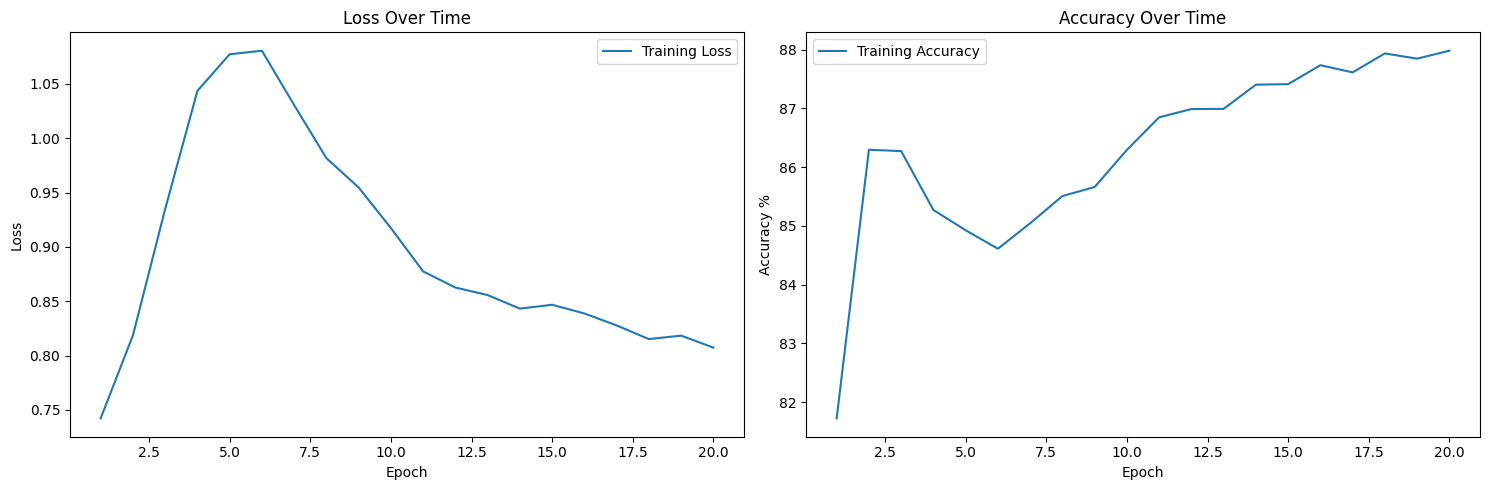


Evaluating on test set...
Test Set Performance:
Loss: 0.4513
Accuracy: 92.44%


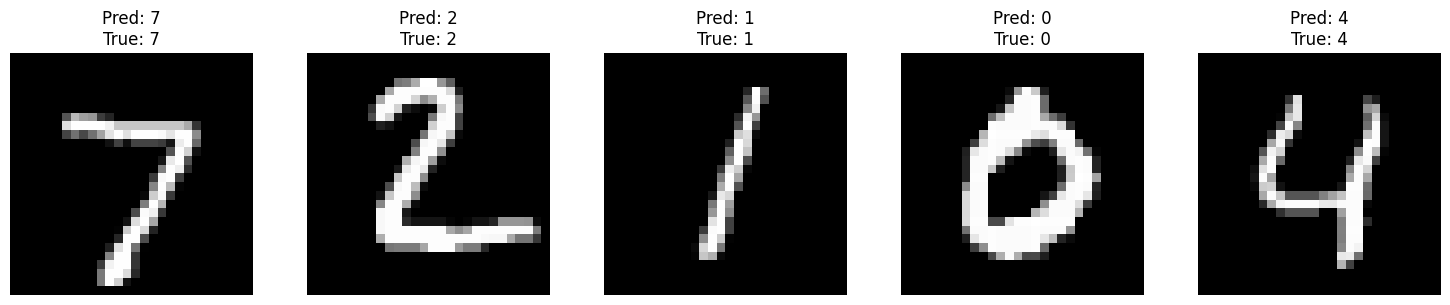

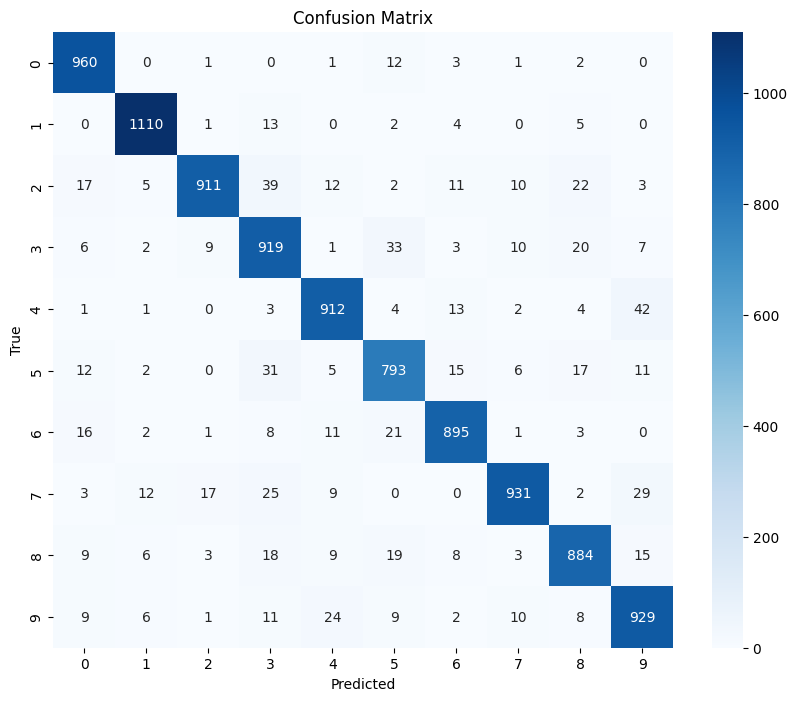


Detailed metrics for each digit:
Digit 0 accuracy: 97.96%
Digit 1 accuracy: 97.80%
Digit 2 accuracy: 88.28%
Digit 3 accuracy: 90.99%
Digit 4 accuracy: 92.87%
Digit 5 accuracy: 88.90%
Digit 6 accuracy: 93.42%
Digit 7 accuracy: 90.56%
Digit 8 accuracy: 90.76%
Digit 9 accuracy: 92.07%


In [79]:
# leaky relu with gentle learning rate - no decay - no regularization - momentum optimiser
nn = NeuraNetwork(
    in_nodes=784,             # 28x28 pixels flattened
    out_nodes=10,             # 10 digits
    hidden_layers=[128, 64],  
    hidden_activation=LeakyReLULayer(),    
    output_activation=SoftmaxLayer(),   
    dropoutRate=0.2,          
    initialization='he',
    learning_rate=0.001,      
    epochs=20,                
    optimizer='momentum',     
    momentum=0.9             
)

print("Starting training...")
history = nn.train(train_images, train_labels_one_hot)

plt.figure(figsize=(15, 5))

#loss graph
plt.subplot(1, 2, 1)
plt.plot(range(1, nn.epochs + 1), history['loss'], label='Training Loss')
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#accuracy graph
plt.subplot(1, 2, 2)
plt.plot(range(1, nn.epochs + 1), history['accuracy'], label='Training Accuracy')
plt.title('Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.legend()

plt.tight_layout()
plt.show()

#test set
print("\nEvaluating on test set...")
test_predictions = nn.run(test_images.T)
predicted_classes = np.argmax(test_predictions, axis=0)
true_classes = np.argmax(test_labels_one_hot, axis=1)

test_loss = nn.cross_entropy_loss(test_predictions, test_labels_one_hot.T) / len(test_labels_one_hot)
test_accuracy = np.mean(predicted_classes == true_classes) * 100
print(f"Test Set Performance:")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_accuracy:.2f}%")

num_samples = 5
plt.figure(figsize=(15, 3))

for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    test_sample = test_images[i]
    sample_prediction = nn.run(test_sample[:, None])
    predicted_class = np.argmax(sample_prediction)
    true_class = np.argmax(test_labels_one_hot[i])

    plt.imshow(test_sample.reshape(28, 28), cmap='gray')
    plt.title(f'Pred: {predicted_class}\nTrue: {true_class}')
    plt.axis('off')

plt.tight_layout()
plt.show()

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print("\nDetailed metrics for each digit:")
for digit in range(10):
    mask = (true_classes == digit)
    digit_accuracy = (predicted_classes[mask] == true_classes[mask]).mean() * 100
    print(f"Digit {digit} accuracy: {digit_accuracy:.2f}%")


#### leaky relu - He - gentle learning rate - no decay - l2 reg - momentum optimiser - 3 hidden layers

Starting training...
Epoch 1/20 - Loss: 1.1903 - Accuracy: 73.55% - LR: 0.001000
Epoch 2/20 - Loss: 1.5196 - Accuracy: 76.84% - LR: 0.001000
Epoch 3/20 - Loss: 1.3710 - Accuracy: 78.05% - LR: 0.001000
Epoch 4/20 - Loss: 1.2701 - Accuracy: 79.85% - LR: 0.001000
Epoch 5/20 - Loss: 1.2267 - Accuracy: 80.68% - LR: 0.001000
Epoch 6/20 - Loss: 1.2132 - Accuracy: 81.12% - LR: 0.001000
Epoch 7/20 - Loss: 1.1967 - Accuracy: 81.63% - LR: 0.001000
Epoch 8/20 - Loss: 1.2074 - Accuracy: 81.72% - LR: 0.001000
Epoch 9/20 - Loss: 1.1682 - Accuracy: 81.89% - LR: 0.001000
Epoch 10/20 - Loss: 1.1152 - Accuracy: 82.53% - LR: 0.001000
Epoch 11/20 - Loss: 1.0754 - Accuracy: 83.37% - LR: 0.001000
Epoch 12/20 - Loss: 1.0768 - Accuracy: 83.26% - LR: 0.001000
Epoch 13/20 - Loss: 1.0646 - Accuracy: 83.83% - LR: 0.001000
Epoch 14/20 - Loss: 1.0467 - Accuracy: 84.09% - LR: 0.001000
Epoch 15/20 - Loss: 1.0264 - Accuracy: 84.51% - LR: 0.001000
Epoch 16/20 - Loss: 1.0240 - Accuracy: 84.40% - LR: 0.001000
Epoch 17/20 

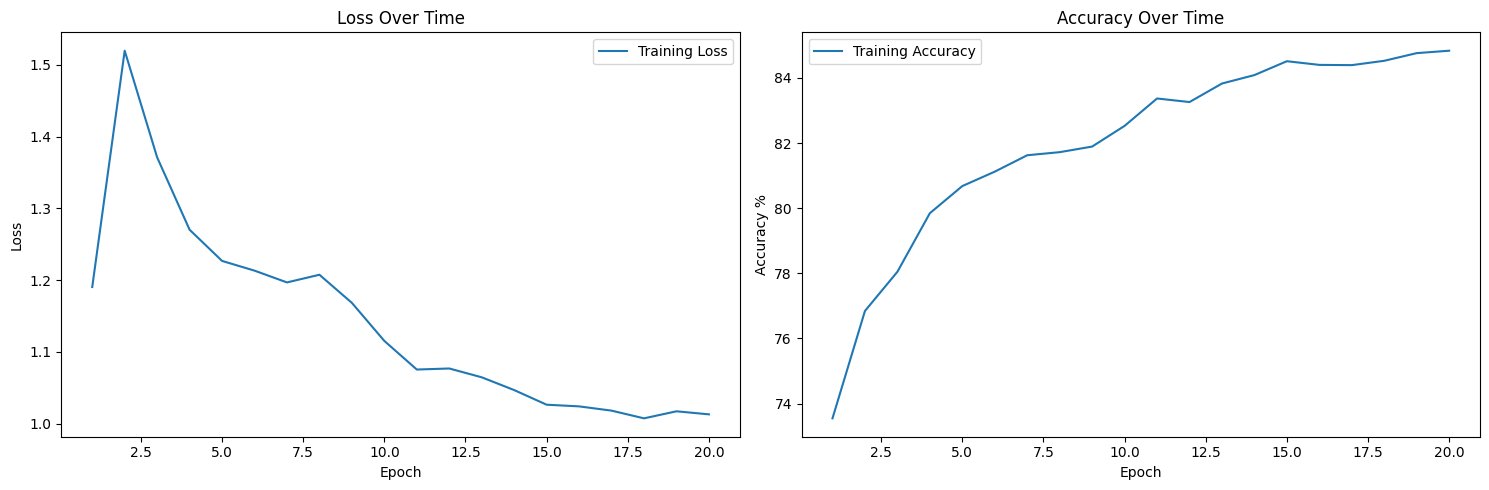


Evaluating on test set...
Test Set Performance:
Loss: 0.4872
Accuracy: 91.74%


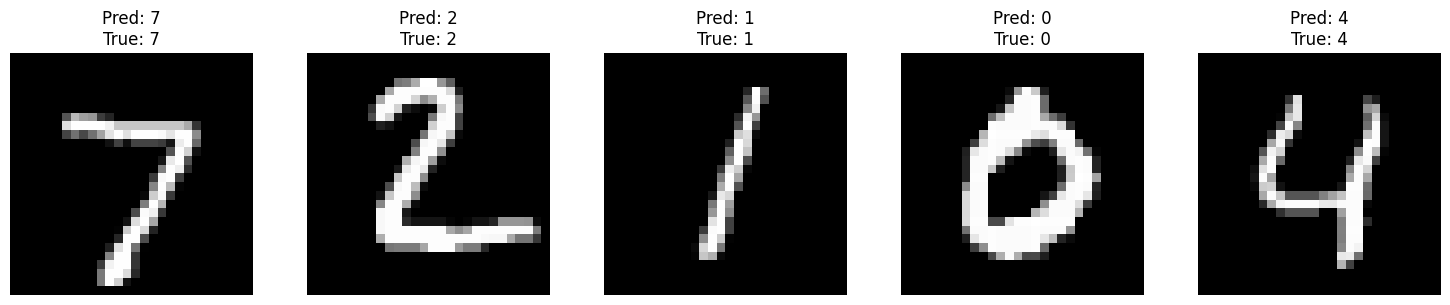

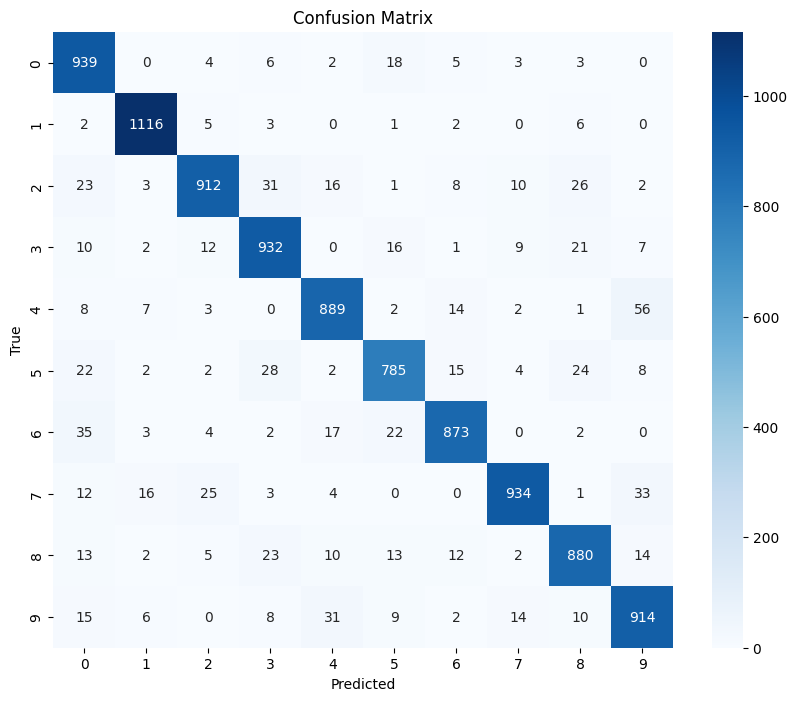


Detailed metrics for each digit:
Digit 0 accuracy: 95.82%
Digit 1 accuracy: 98.33%
Digit 2 accuracy: 88.37%
Digit 3 accuracy: 92.28%
Digit 4 accuracy: 90.53%
Digit 5 accuracy: 88.00%
Digit 6 accuracy: 91.13%
Digit 7 accuracy: 90.86%
Digit 8 accuracy: 90.35%
Digit 9 accuracy: 90.58%


In [80]:
# leaky relu with gentle learning rate - no decay - l2 reg - momentum optimiser
nn = NeuraNetwork(
    in_nodes=784,             # 28x28 pixels flattened
    out_nodes=10,             # 10 digits
    hidden_layers=[128, 64, 32],  
    hidden_activation=LeakyReLULayer(),    
    output_activation=SoftmaxLayer(),   
    initialization='he',
    dropoutRate=0.2,          
    learning_rate=0.001,      
    epochs=20,                
    optimizer='momentum',     
    momentum=0.9,            
)

print("Starting training...")
history = nn.train(train_images, train_labels_one_hot)

plt.figure(figsize=(15, 5))

#loss graph
plt.subplot(1, 2, 1)
plt.plot(range(1, nn.epochs + 1), history['loss'], label='Training Loss')
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#accuracy graph
plt.subplot(1, 2, 2)
plt.plot(range(1, nn.epochs + 1), history['accuracy'], label='Training Accuracy')
plt.title('Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.legend()

plt.tight_layout()
plt.show()

#test set
print("\nEvaluating on test set...")
test_predictions = nn.run(test_images.T)
predicted_classes = np.argmax(test_predictions, axis=0)
true_classes = np.argmax(test_labels_one_hot, axis=1)

test_loss = nn.cross_entropy_loss(test_predictions, test_labels_one_hot.T) / len(test_labels_one_hot)
test_accuracy = np.mean(predicted_classes == true_classes) * 100
print(f"Test Set Performance:")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_accuracy:.2f}%")

num_samples = 5
plt.figure(figsize=(15, 3))

for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    test_sample = test_images[i]
    sample_prediction = nn.run(test_sample[:, None])
    predicted_class = np.argmax(sample_prediction)
    true_class = np.argmax(test_labels_one_hot[i])

    plt.imshow(test_sample.reshape(28, 28), cmap='gray')
    plt.title(f'Pred: {predicted_class}\nTrue: {true_class}')
    plt.axis('off')

plt.tight_layout()
plt.show()

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print("\nDetailed metrics for each digit:")
for digit in range(10):
    mask = (true_classes == digit)
    digit_accuracy = (predicted_classes[mask] == true_classes[mask]).mean() * 100
    print(f"Digit {digit} accuracy: {digit_accuracy:.2f}%")


#### leaky relu - He - agressive learning - no decay - L2 - momentum - 3 hidden layers

Starting training...
Epoch 1/20 - Loss: 2.3080 - Accuracy: 52.64% - LR: 0.010000
Epoch 2/20 - Loss: 2.7986 - Accuracy: 38.16% - LR: 0.010000
Epoch 3/20 - Loss: 2.7235 - Accuracy: 17.83% - LR: 0.010000
Epoch 4/20 - Loss: 2.4139 - Accuracy: 14.39% - LR: 0.010000
Epoch 5/20 - Loss: 2.3780 - Accuracy: 15.30% - LR: 0.010000
Epoch 6/20 - Loss: 2.3558 - Accuracy: 16.04% - LR: 0.010000
Epoch 7/20 - Loss: 2.3271 - Accuracy: 16.39% - LR: 0.010000
Epoch 8/20 - Loss: 2.3120 - Accuracy: 16.49% - LR: 0.010000
Epoch 9/20 - Loss: 2.2994 - Accuracy: 16.66% - LR: 0.010000
Epoch 10/20 - Loss: 2.2967 - Accuracy: 16.80% - LR: 0.010000
Epoch 11/20 - Loss: 2.2908 - Accuracy: 16.81% - LR: 0.010000
Epoch 12/20 - Loss: 2.2853 - Accuracy: 16.99% - LR: 0.010000
Epoch 13/20 - Loss: 2.2891 - Accuracy: 16.89% - LR: 0.010000
Epoch 14/20 - Loss: 2.2949 - Accuracy: 16.78% - LR: 0.010000
Epoch 15/20 - Loss: 2.2884 - Accuracy: 16.94% - LR: 0.010000
Epoch 16/20 - Loss: 2.2822 - Accuracy: 16.86% - LR: 0.010000
Epoch 17/20 

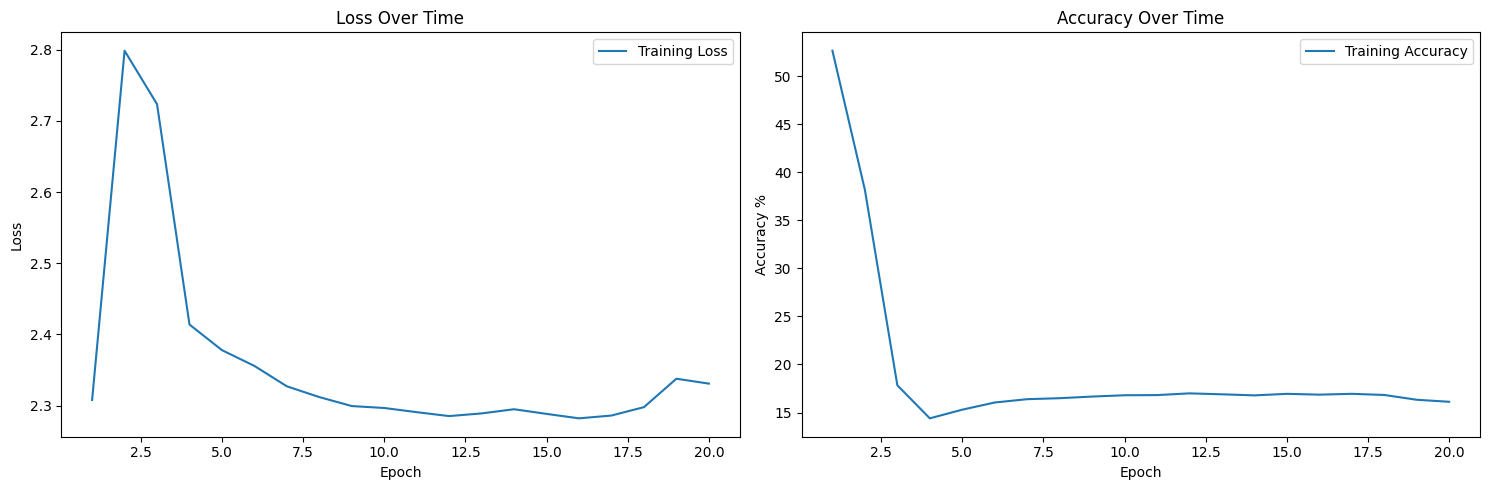


Evaluating on test set...
Test Set Performance:
Loss: 2.0857
Accuracy: 19.47%


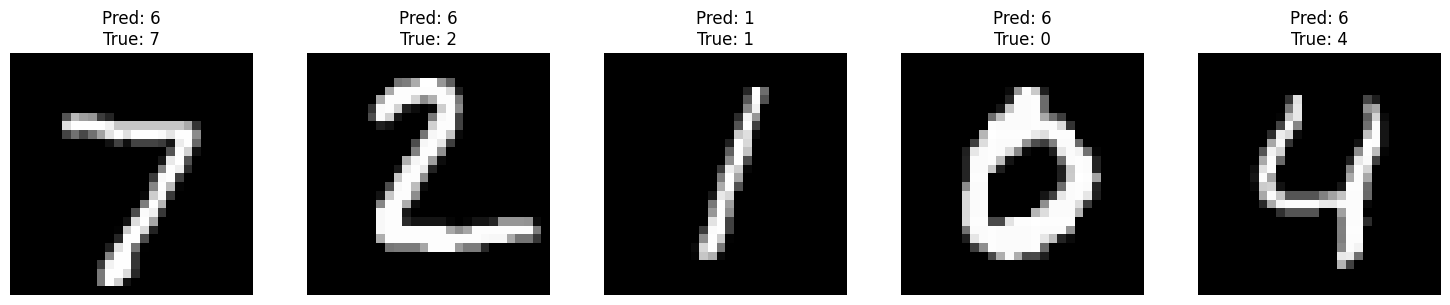

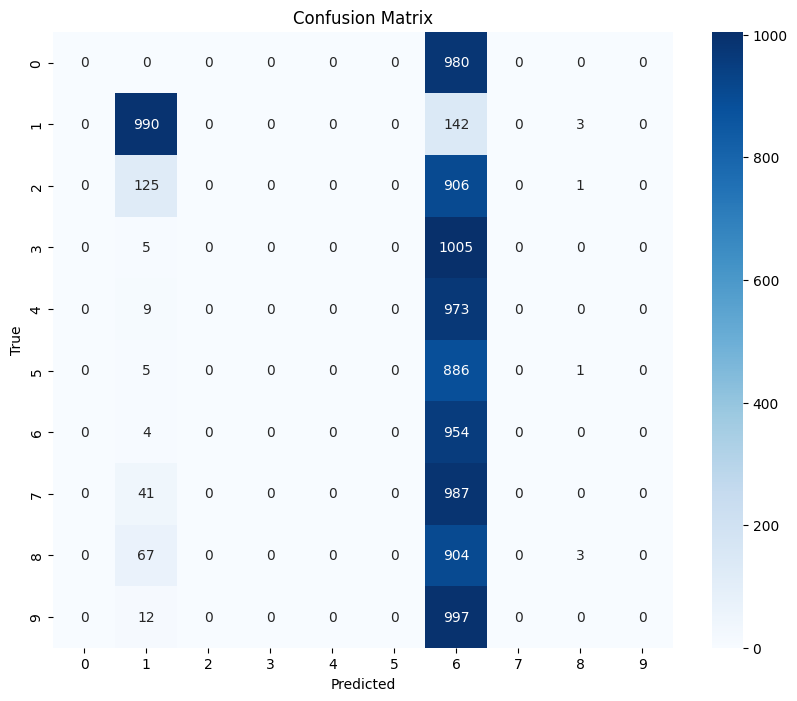


Detailed metrics for each digit:
Digit 0 accuracy: 0.00%
Digit 1 accuracy: 87.22%
Digit 2 accuracy: 0.00%
Digit 3 accuracy: 0.00%
Digit 4 accuracy: 0.00%
Digit 5 accuracy: 0.00%
Digit 6 accuracy: 99.58%
Digit 7 accuracy: 0.00%
Digit 8 accuracy: 0.31%
Digit 9 accuracy: 0.00%


In [81]:
# leaky relu with aggressive learning rate - no decay - l2 reg - momentum optimiser
nn = NeuraNetwork(
    in_nodes=784,             # 28x28 pixels flattened
    out_nodes=10,             # 10 digits
    hidden_layers=[128, 64, 32],  
    hidden_activation=LeakyReLULayer(),    
    output_activation=SoftmaxLayer(),   
    initialization='he',
    dropoutRate=0.2,          
    learning_rate=0.01,      
    epochs=20,                
    optimizer='momentum',     
    momentum=0.9,
    regularization='L2',
    lambda_=0.001,             
)

print("Starting training...")
history = nn.train(train_images, train_labels_one_hot)

plt.figure(figsize=(15, 5))

#loss graph
plt.subplot(1, 2, 1)
plt.plot(range(1, nn.epochs + 1), history['loss'], label='Training Loss')
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#accuracy graph
plt.subplot(1, 2, 2)
plt.plot(range(1, nn.epochs + 1), history['accuracy'], label='Training Accuracy')
plt.title('Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.legend()

plt.tight_layout()
plt.show()

#test set
print("\nEvaluating on test set...")
test_predictions = nn.run(test_images.T)
predicted_classes = np.argmax(test_predictions, axis=0)
true_classes = np.argmax(test_labels_one_hot, axis=1)

test_loss = nn.cross_entropy_loss(test_predictions, test_labels_one_hot.T) / len(test_labels_one_hot)
test_accuracy = np.mean(predicted_classes == true_classes) * 100
print(f"Test Set Performance:")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_accuracy:.2f}%")

num_samples = 5
plt.figure(figsize=(15, 3))

for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    test_sample = test_images[i]
    sample_prediction = nn.run(test_sample[:, None])
    predicted_class = np.argmax(sample_prediction)
    true_class = np.argmax(test_labels_one_hot[i])

    plt.imshow(test_sample.reshape(28, 28), cmap='gray')
    plt.title(f'Pred: {predicted_class}\nTrue: {true_class}')
    plt.axis('off')

plt.tight_layout()
plt.show()

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print("\nDetailed metrics for each digit:")
for digit in range(10):
    mask = (true_classes == digit)
    digit_accuracy = (predicted_classes[mask] == true_classes[mask]).mean() * 100
    print(f"Digit {digit} accuracy: {digit_accuracy:.2f}%")


#### old intial testing

starting training...
epoch 1/20 - loss: 2.5460567004843107 - accuracy: 10.698148148148148% - LR: 0.001
epoch 2/20 - loss: 2.5437522646794224 - accuracy: 10.540740740740741% - LR: 0.001
epoch 3/20 - loss: 2.544038265109265 - accuracy: 10.574074074074074% - LR: 0.001
epoch 4/20 - loss: 2.543134097821502 - accuracy: 10.937037037037037% - LR: 0.001
epoch 5/20 - loss: 2.5396010078863274 - accuracy: 10.642592592592592% - LR: 0.001
epoch 6/20 - loss: 2.539838830597563 - accuracy: 10.50925925925926% - LR: 0.00095
epoch 7/20 - loss: 2.5416604798929385 - accuracy: 10.603703703703705% - LR: 0.00095
epoch 8/20 - loss: 2.538264772959786 - accuracy: 10.522222222222222% - LR: 0.00095
epoch 9/20 - loss: 2.5364806543025833 - accuracy: 10.603703703703705% - LR: 0.00095
epoch 10/20 - loss: 2.53218693490011 - accuracy: 10.712962962962964% - LR: 0.00095
epoch 11/20 - loss: 2.5354632395251255 - accuracy: 10.635185185185184% - LR: 0.0009025
epoch 12/20 - loss: 2.535815338621164 - accuracy: 10.572222222222221

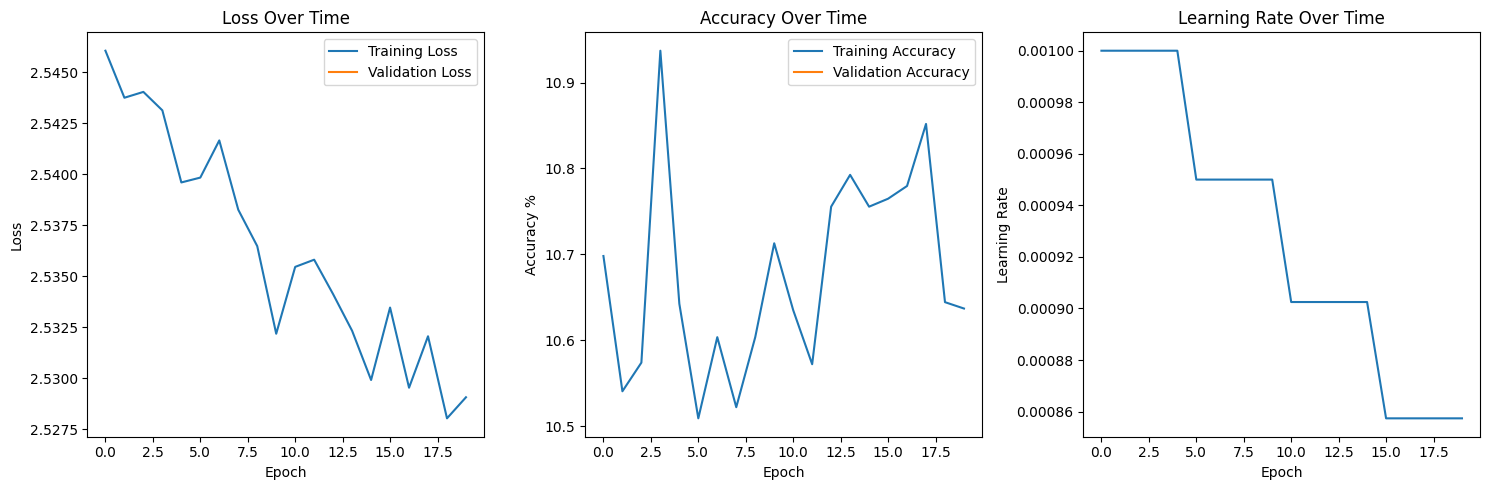


Evaluating on test set...
Test Set Performance:
Loss: 2.4795
Accuracy: 10.10%


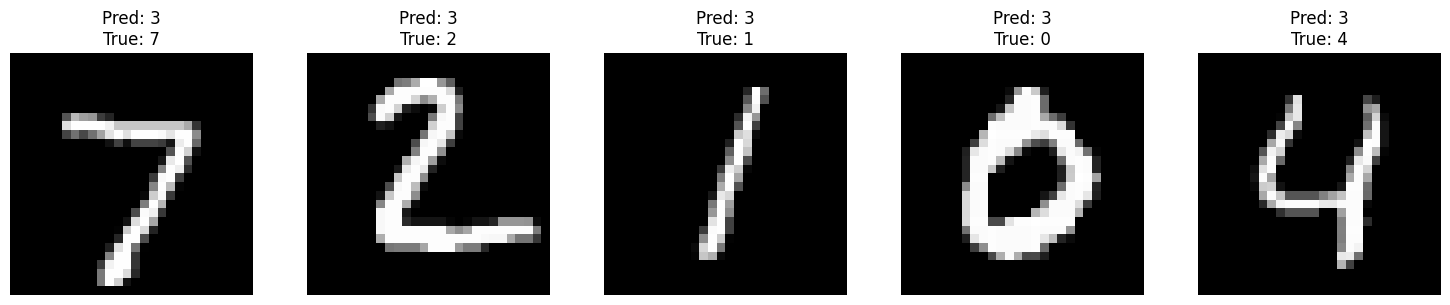

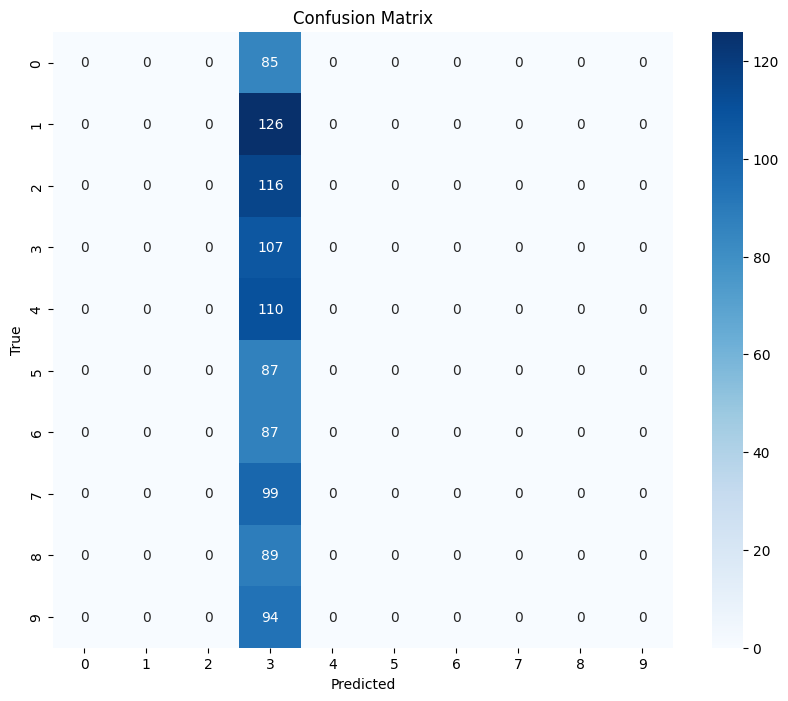


Detailed metrics for each digit:
Digit 0 accuracy: 0.00%
Digit 1 accuracy: 0.00%
Digit 2 accuracy: 0.00%
Digit 3 accuracy: 100.00%
Digit 4 accuracy: 0.00%
Digit 5 accuracy: 0.00%
Digit 6 accuracy: 0.00%
Digit 7 accuracy: 0.00%
Digit 8 accuracy: 0.00%
Digit 9 accuracy: 0.00%


In [ ]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

train_images = mnist_train.data.numpy().reshape(-1, 28*28) / 255.0
train_labels = mnist_train.targets.numpy()
test_images = mnist_test.data.numpy().reshape(-1, 28*28) / 255.0
test_labels = mnist_test.targets.numpy()

val_size = len(train_images) // 10
val_images = train_images[:val_size]
val_labels = train_labels[:val_size]
train_images = train_images[val_size:]
train_labels = train_labels[val_size:]

def one_hot_encode(labels, num_classes=10):
    return np.eye(num_classes)[labels]

train_labels_one_hot = one_hot_encode(train_labels)
val_labels_one_hot = one_hot_encode(val_labels)
test_labels_one_hot = one_hot_encode(test_labels)

#this will be my baseline
nn = NeuraNetwork(
    in_nodes=784,             #28x28 pixels flattened
    out_nodes=10,             #10 digits
    hidden_layers=[128, 64],  #two hidden layers
    hidden_activation=SigmoidLayer(),    #sigmoid for hidden layers
    output_activation=SoftmaxLayer(),    #softmax for output layer
    dropoutRate=0.2,
    learning_rate=0.001,
    epochs=20
)

print("starting training...")
history = nn.train(train_images, train_labels_one_hot)

plt.figure(figsize=(15, 5))

#loss
plt.subplot(1, 3, 1)
plt.plot(history['loss'], label='Training Loss')
if 'val_loss' in history:
    plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#accuracy
plt.subplot(1, 3, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
if 'val_accuracy' in history:
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.legend()

#learning rate
plt.subplot(1, 3, 3)
plt.plot(history['learning_rate'])
plt.title('Learning Rate Over Time')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')

plt.tight_layout()
plt.show()

#test set eval
print("\nEvaluating on test set...")
test_predictions, test_metrics = nn.run(test_images, test_labels_one_hot)
print(f"Test Set Performance:")
print(f"Loss: {test_metrics['loss']:.4f}")
print(f"Accuracy: {test_metrics['accuracy']:.2f}%")

num_samples = 5
plt.figure(figsize=(15, 3))

for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    
    #single sample prediction
    test_sample = test_images[i]
    predictions = nn.run(test_sample)
    predicted_class = np.argmax(predictions)
    true_class = np.argmax(test_labels_one_hot[i])
    
    plt.imshow(test_sample.reshape(28, 28), cmap='gray')
    plt.title(f'Pred: {predicted_class}\nTrue: {true_class}')
    plt.axis('off')

plt.tight_layout()
plt.show()

from sklearn.metrics import confusion_matrix
import seaborn as sns
test_subset = test_images[:1000]
predictions_subset = nn.run(test_subset)
predicted_classes = np.argmax(predictions_subset, axis=1)
true_classes = np.argmax(test_labels_one_hot[:1000], axis=1)

#confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#metrics
print("\nDetailed metrics for each digit:")
for digit in range(10):
    mask = true_classes == digit
    digit_acc = (predicted_classes[mask] == true_classes[mask]).mean() * 100
    print(f"Digit {digit} accuracy: {digit_acc:.2f}%")